#### Imports

In [21]:
%load_ext autoreload
%autoreload 2
%env PROJ_LIB=/home/wwymak/anaconda3/envs/solaris/share/proj
%matplotlib inline


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
env: PROJ_LIB=/home/wwymak/anaconda3/envs/solaris/share/proj


In [78]:
from fastai.vision import *
import tifffile as tiff
import shapely.wkt
import geopandas as gpd
import numpy as np
import cv2

In [6]:
data_dir = Path("/media/wwymak/Storage/spacenet_roads")

In [7]:
import solaris as sol
import skimage
import geopandas as gpd
from matplotlib import pyplot as plt
from shapely.ops import cascaded_union


#### data --files

In [8]:
train_dir = data_dir / "AOI_3_Paris_Roads_Train"
train_dir.ls()

[PosixPath('/media/wwymak/Storage/spacenet_roads/AOI_3_Paris_Roads_Train/RGB-PanSharpen'),
 PosixPath('/media/wwymak/Storage/spacenet_roads/AOI_3_Paris_Roads_Train/MUL-PanSharpen'),
 PosixPath('/media/wwymak/Storage/spacenet_roads/AOI_3_Paris_Roads_Train/MUL'),
 PosixPath('/media/wwymak/Storage/spacenet_roads/AOI_3_Paris_Roads_Train/summaryData'),
 PosixPath('/media/wwymak/Storage/spacenet_roads/AOI_3_Paris_Roads_Train/PAN'),
 PosixPath('/media/wwymak/Storage/spacenet_roads/AOI_3_Paris_Roads_Train/geojson')]

In [13]:
(train_dir / "geojson" / "spacenetroads").ls()[:5]

[PosixPath('/media/wwymak/Storage/spacenet_roads/AOI_3_Paris_Roads_Train/geojson/spacenetroads/spacenetroads_AOI_3_Paris_img75.geojson'),
 PosixPath('/media/wwymak/Storage/spacenet_roads/AOI_3_Paris_Roads_Train/geojson/spacenetroads/spacenetroads_AOI_3_Paris_img414.geojson'),
 PosixPath('/media/wwymak/Storage/spacenet_roads/AOI_3_Paris_Roads_Train/geojson/spacenetroads/spacenetroads_AOI_3_Paris_img11.geojson'),
 PosixPath('/media/wwymak/Storage/spacenet_roads/AOI_3_Paris_Roads_Train/geojson/spacenetroads/spacenetroads_AOI_3_Paris_img47.geojson'),
 PosixPath('/media/wwymak/Storage/spacenet_roads/AOI_3_Paris_Roads_Train/geojson/spacenetroads/spacenetroads_AOI_3_Paris_img393.geojson')]

In [10]:
(train_dir / "RGB-PanSharpen").ls()[:5]

[PosixPath('/media/wwymak/Storage/spacenet_roads/AOI_3_Paris_Roads_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_3_Paris_img359.tif'),
 PosixPath('/media/wwymak/Storage/spacenet_roads/AOI_3_Paris_Roads_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_3_Paris_img268.tif'),
 PosixPath('/media/wwymak/Storage/spacenet_roads/AOI_3_Paris_Roads_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_3_Paris_img173.tif'),
 PosixPath('/media/wwymak/Storage/spacenet_roads/AOI_3_Paris_Roads_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_3_Paris_img160.tif'),
 PosixPath('/media/wwymak/Storage/spacenet_roads/AOI_3_Paris_Roads_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_3_Paris_img28.tif')]

#### dataviewing

In [35]:
def scale_percentile(matrix):
    # scale tiff files read by tifffile to an rgb format readable by e.g. mpl for display
    w, h, d = matrix.shape
    matrix = np.reshape(matrix, [w * h, d]).astype(np.float64)
    # Get 2nd and 98th percentile
    mins = np.percentile(matrix, 1, axis=0)
    maxs = np.percentile(matrix, 99, axis=0) - mins
    matrix = (matrix - mins[None, :]) / maxs[None, :]
    matrix = np.reshape(matrix, [w, h, d])
    matrix = matrix.clip(0, 1)
    return matrix

In [73]:
def plot_mask_img(img_id, road_mask_width=4):
    mask_fname = train_dir / "geojson" / "spacenetroads"/f"spacenetroads_{img_id}.geojson"

    road_mask = sol.vector.mask.road_mask(str(mask_fname),
                                          reference_im=str(train_dir /"RGB-PanSharpen" / f"RGB-PanSharpen_{img_id}.tif"),
                                          width=road_mask_width, meters=True)

    # f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
    f = plt.figure(figsize=(10,6))
    plt.subplot(121)
    img_rgb = tiff.imread(str(train_dir /"RGB-PanSharpen" / f"RGB-PanSharpen_{img_id}.tif"))

    tiff.imshow(255 * scale_percentile(img_rgb), figure=f, subplot=121);
    plt.subplot(122)
    plt.imshow(road_mask, cmap='gray');

In [66]:
summary_data = pd.read_csv("/media/wwymak/Storage/spacenet_roads/AOI_3_Paris_Roads_Train/summaryData/AOI_3_Paris_Roads_Train.csv")


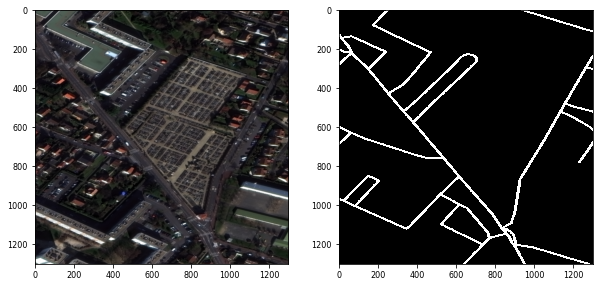

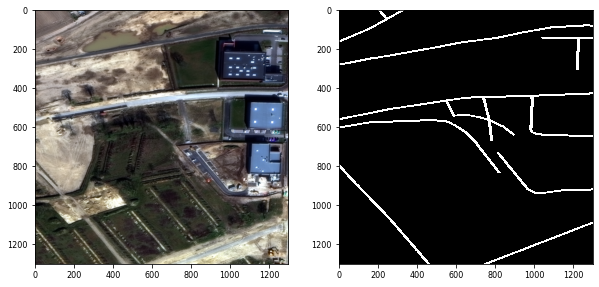

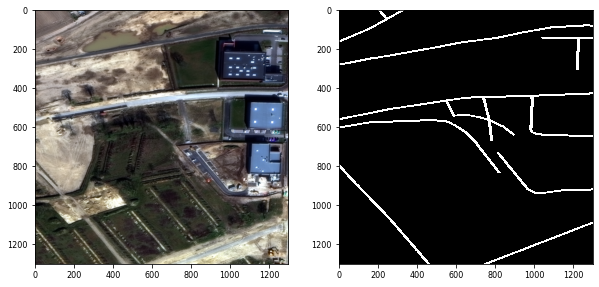

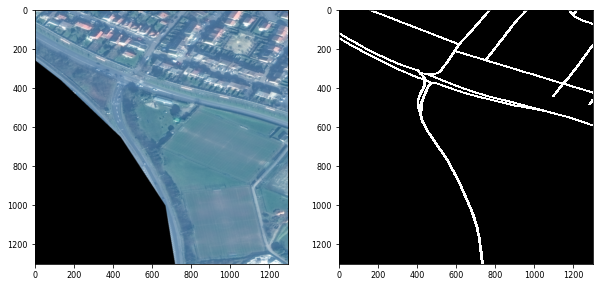

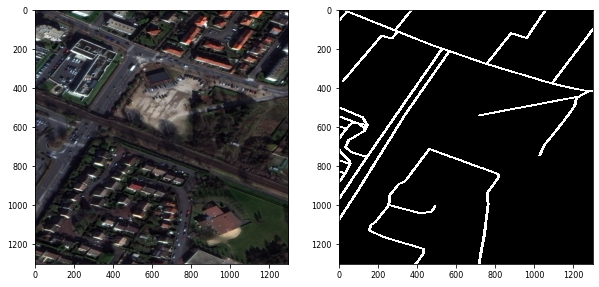

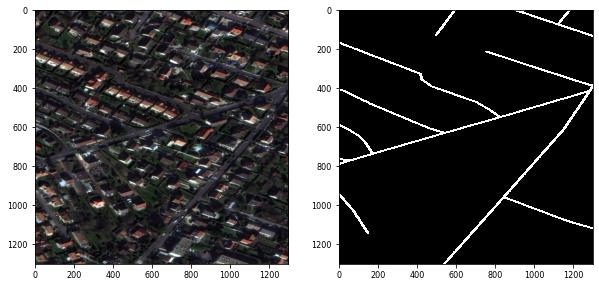

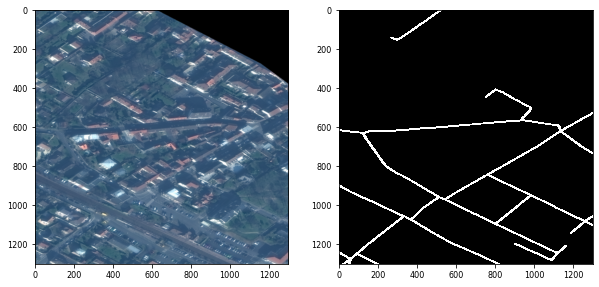

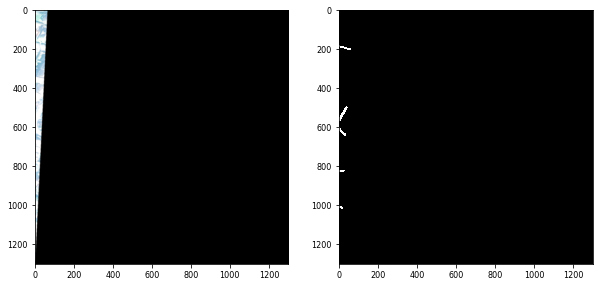

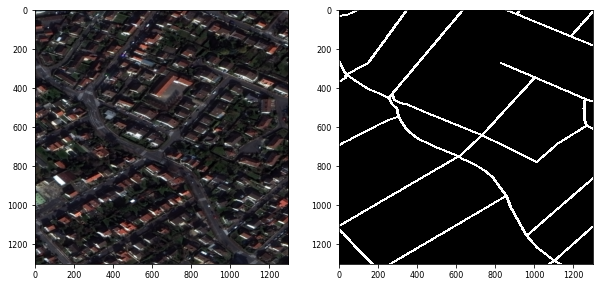

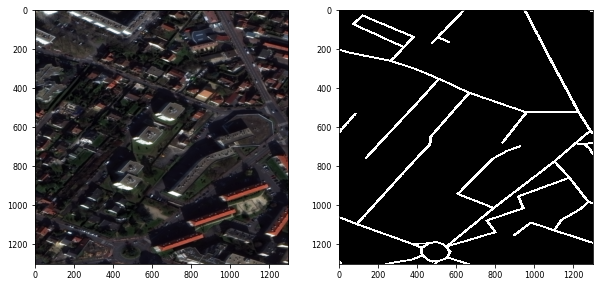

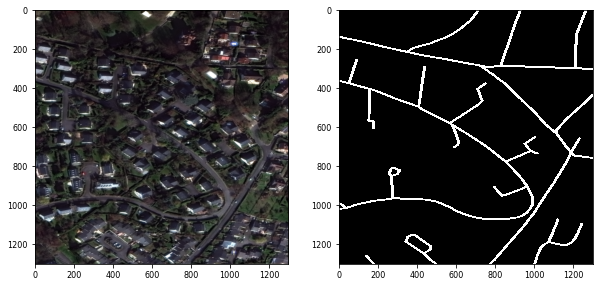

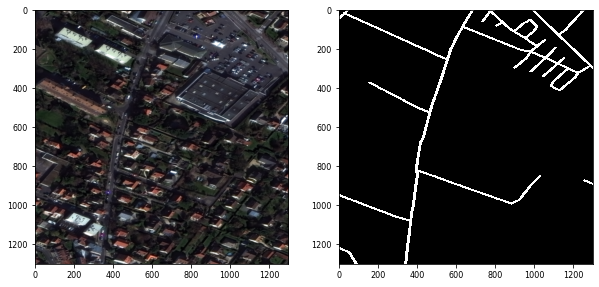

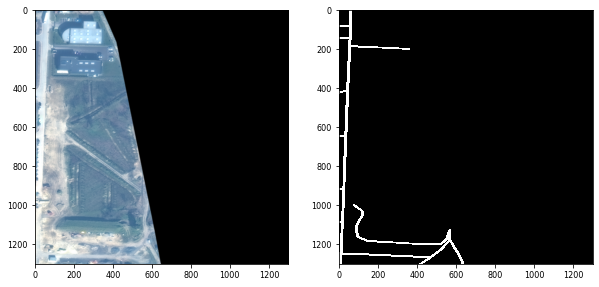

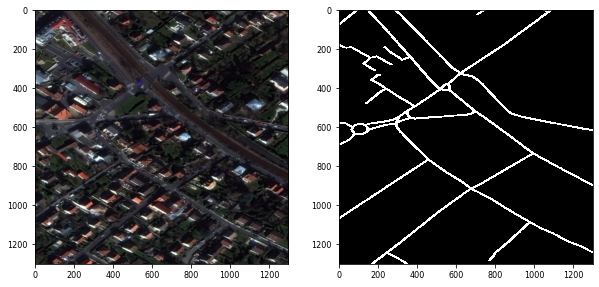

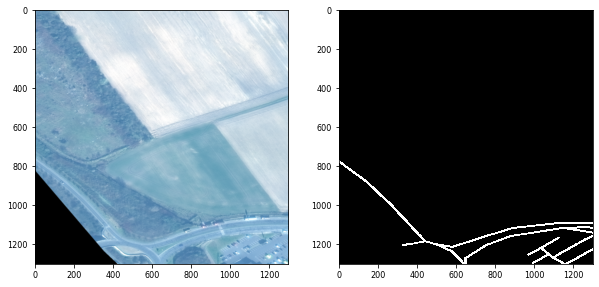

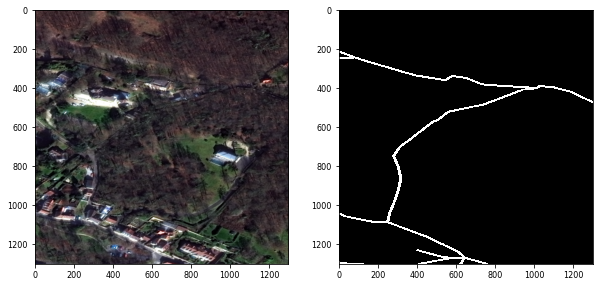

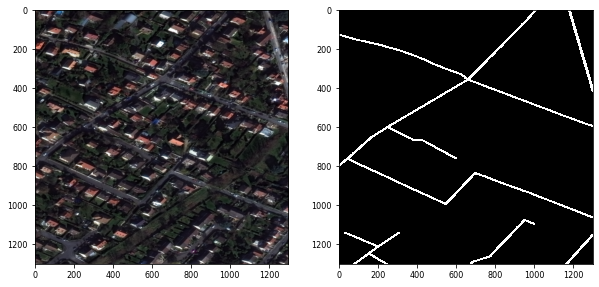

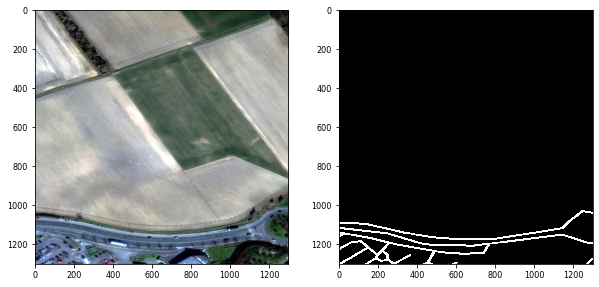

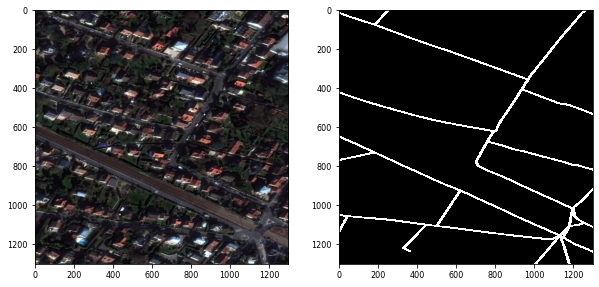

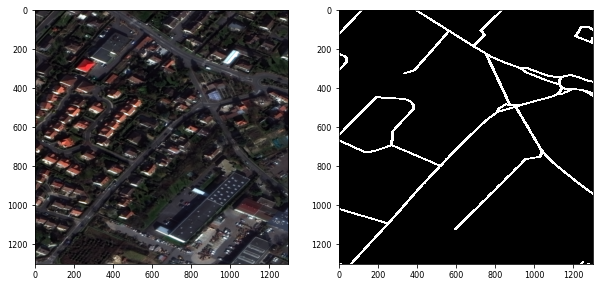

In [76]:
img_ids =  np.random.choice(summary_data.ImageId, 20, replace=False)
[plot_mask_img(img_id,3) for img_id in img_ids];

as nvidia mentioned in their blog post, it's quite hard to get an accurate segmentation mask for roads using linestrings. 

In [150]:
def plot_mask_img2(img_id, road_mask_width=4, loDiff=30, upDiff=30):
    mask_fname = train_dir / "geojson" / "spacenetroads"/f"spacenetroads_{img_id}.geojson"

    road_mask = sol.vector.mask.road_mask(str(mask_fname),
                                          reference_im=str(train_dir /"RGB-PanSharpen" / f"RGB-PanSharpen_{img_id}.tif"),
                                          width=road_mask_width, meters=True)
    
    img_rgb = tiff.imread(str(train_dir /"RGB-PanSharpen" / f"RGB-PanSharpen_{img_id}.tif"))

    img_rgb = (255 * scale_percentile(img_rgb)).astype(np.uint8)
    h, w, d = img_rgb.shape
    mask = np.zeros((h+2,w+2),np.uint8)
    for x, y  in np.argwhere(road_mask == 255):
        num,img_rgb,mask,rect = cv2.floodFill(img_rgb, mask, 
                                         seedPoint=(y, x),newVal=255, loDiff=[loDiff,]*3,
                                              upDiff=[upDiff,] * 3, flags=cv2.FLOODFILL_MASK_ONLY)

    # f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
    f = plt.figure(figsize=(12,6))
    plt.subplot(121)
    

    tiff.imshow(255 * scale_percentile(img_rgb), figure=f, subplot=131);
    plt.subplot(132)
    plt.imshow(road_mask, cmap='gray');
    
    plt.subplot(133)
    plt.imshow(mask, cmap='gray');

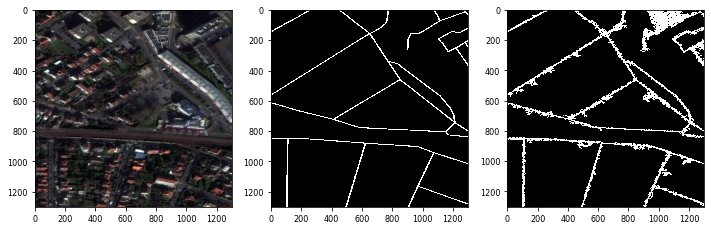

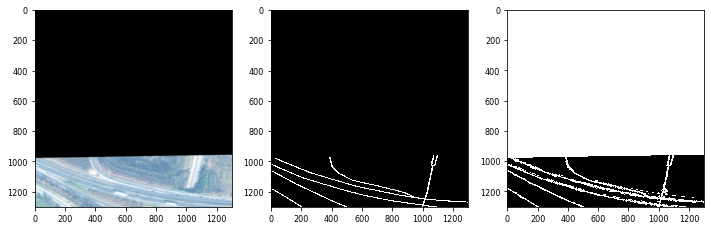

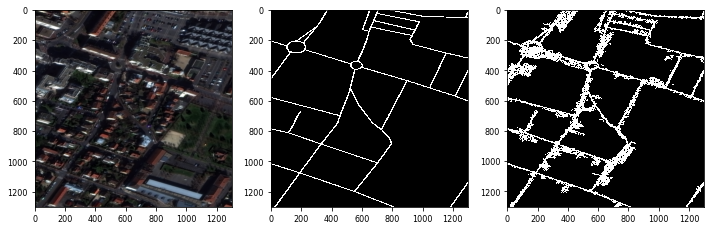

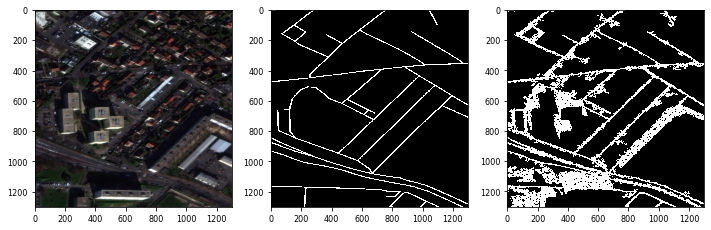

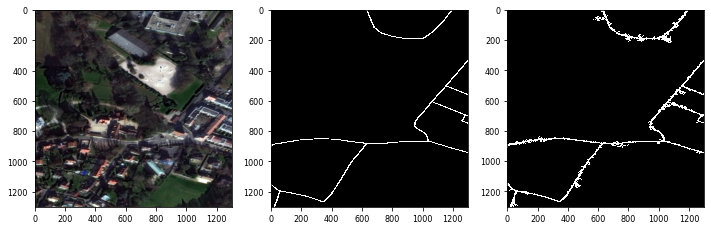

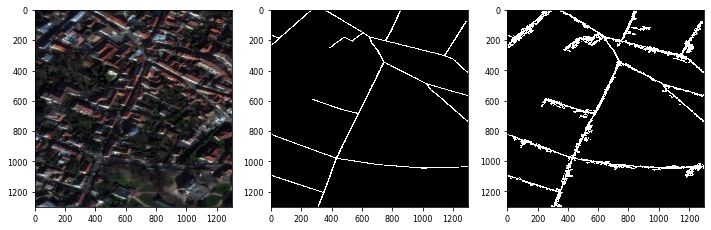

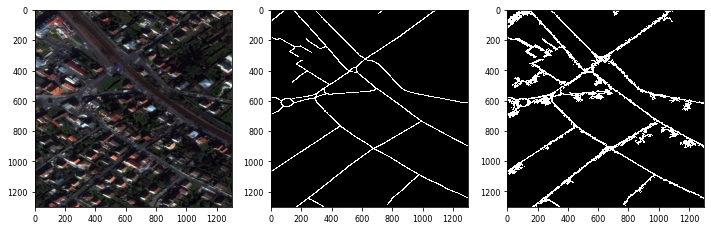

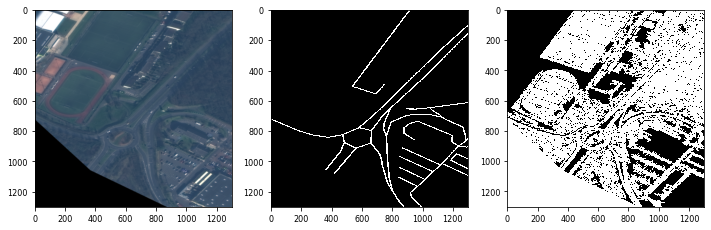

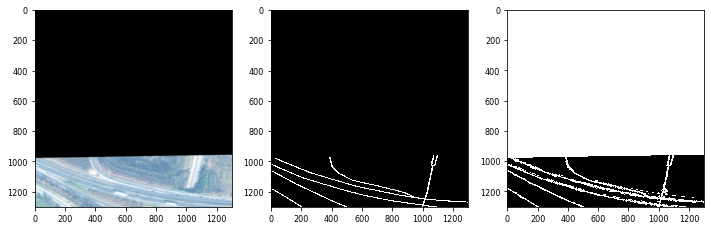

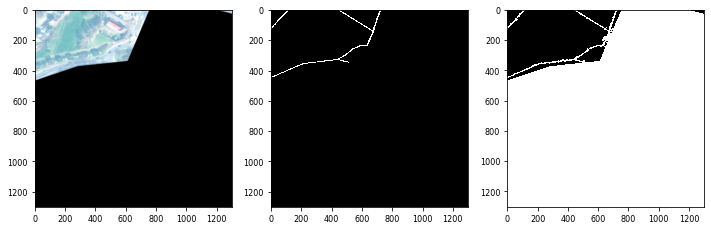

In [154]:
img_ids =  np.random.choice(summary_data.ImageId, 10, replace=False)
[plot_mask_img2(img_id,2, loDiff=3, upDiff=3) for img_id in img_ids];

In [90]:
img_id = summary_data.ImageId[0]
road_mask_width=2
mask_fname = train_dir / "geojson" / "spacenetroads"/f"spacenetroads_{img_id}.geojson"

road_mask = sol.vector.mask.road_mask(str(mask_fname),
                                      reference_im=str(train_dir /"RGB-PanSharpen" / f"RGB-PanSharpen_{img_id}.tif"),
                                      width=road_mask_width, meters=True)


img_rgb = tiff.imread(str(train_dir /"RGB-PanSharpen" / f"RGB-PanSharpen_{img_id}.tif"))


In [137]:
h, w, d = img_rgb.shape
mask = np.zeros((h+2,w+2),np.uint8)
im = (255 * scale_percentile(img_rgb)).astype(np.uint8)
for x, y  in np.argwhere(road_mask == 255):
    num,im,mask,rect = cv2.floodFill(im, mask, 
                                     seedPoint=(y, x),newVal=255, loDiff=20, upDiff=10, flags=cv2.FLOODFILL_MASK_ONLY)

# f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
# f = plt.figure(figsize=(10,6))
# plt.subplot(121)


# tiff.imshow(255 * scale_percentile(img_rgb), figure=f, subplot=121);
# plt.subplot(122)
# plt.imshow(road_mask, cmap='gray');

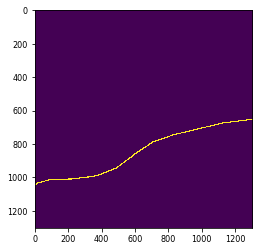

In [138]:
plt.imshow  (mask)                          

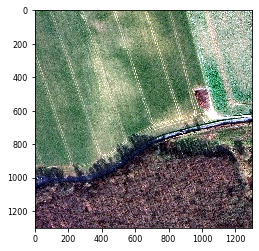

In [140]:
plt.imshow(im)

In [149]:
[30,]*3

[30, 30, 30]